> 📌 **Avant de commencer :**
>
> [![Ouvrir dans Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1maaw5EWIzLsGCAhr8klUagld7osI82cy?usp=sharing)
>
> 🔁 *Veuillez faire une copie dans votre Google Drive (`Fichier > Enregistrer une copie dans Drive`) avant toute modification.*


# Traduction Automatique Neuronale

Bienvenue dans votre premier devoir de programmation de la semaine !

* Vous allez construire un modèle de Traduction Automatique Neuronale (NMT) pour traduire des dates lisibles par l’humain ("25th of June, 2009") en dates lisibles par une machine ("2009-06-25").
* Vous réaliserez cela en utilisant un modèle d’attention, l’un des modèles séquence-à-séquence les plus sophistiqués.

Ce notebook a été réalisé en collaboration avec le Deep Learning Institute de NVIDIA.


## Table des matières

- [Packages](#0)
- [1 - Traduction des dates lisibles par l'humain en dates lisibles par la machine](#1)
    - [1.1 - Jeu de données](#1-1)
- [2 - Traduction automatique neuronale avec attention](#2)
    - [2.1 - Mécanisme d'attention](#2-1)
        - [Exercice 1 - one_step_attention](#ex-1)
        - [Exercice 2 - modelf](#ex-2)
        - [Exercice 3 - Compiler le modèle](#ex-3)
- [3 - Visualisation de l'attention (Optionnel / Non noté)](#3)
    - [3.1 - Obtenir les poids d'attention du réseau](#3-1)


## Installation des paquets

In [ ]:
! pip install faker babel tqdm tensorflow transformers datasets evaluate scikit-learn matplotlib
! pip install solutions
! pip install testCase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for solutions: filename=solutions-0.0.2-py3-none-any.whl size=3363 sha256=bf4b2c1a6b3ca9eab72be0f7634640194c6c92d36f3523035c5007b35e742a21
  Stored in directory: /root/.cache/pip/wheels/c4/75/b0/5ed63fec747fbdf70606f154524d0e1abb9ec159663c88b516
Successfully built solutions


<a name='0'></a>
## Importation des paquets

In [ ]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
#from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline


from termcolor import colored

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector

## **Fonctions**

In [ ]:
def generateTestCases():
	testCases = {
	    'one_step_attention': {
	        'partId': 'zcQIs',
	        'testCases': [
	            {
	                'testInput': 0,
	                'testOutput': m_out2
	            }
	        ]
	    },
	    'model': {
	        'partId': 'PTKef',
	        'testCases': [
	            {
	                'testInput': (Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size),
	                'testOutput': m_out1
	            }
	        ]
	    }
       }
	return testCases

In [ ]:
fake = Faker()
Faker.seed(12345)
random.seed(12345)

# Définir le format des données que nous souhaitons générer
FORMATS = ['short',
           'medium',
           'long',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'd MMM YYY',
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY']

# changer cela si vous voulez utiliser une autre langue
LOCALES = ['en_US']

def load_date():
    """
        Charge quelques dates factices
        :returns: tuple contenant la chaîne lisible par l'humain, la chaîne lisible par la machine, et l'objet date
    """
    dt = fake.date_object()

    try:
        human_readable = format_date(dt, format=random.choice(FORMATS),  locale='en_US')  # locale=random.choice(LOCALES))
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',','')
        machine_readable = dt.isoformat()

    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

def load_dataset(m):
    """
        Charge un jeu de données avec m exemples et vocabulaires
        :m: le nombre d'exemples à générer
    """

    human_vocab = set()
    machine_vocab = set()
    dataset = []
    Tx = 30

    for i in tqdm(range(m)):
        h, m, _ = load_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))

    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'],
                     list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v:k for k,v in inv_machine.items()}

    return dataset, human, machine, inv_machine

def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    X, Y = zip(*dataset)

    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]

    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

    return X, np.array(Y), Xoh, Yoh

def string_to_int(string, length, vocab):
    """
    Convertit toutes les chaînes du vocabulaire en liste d'entiers représentant les positions
    des caractères de la chaîne d'entrée dans le vocabulaire "vocab".

    Arguments:
    string -- chaîne d'entrée, par ex. 'Wed 10 Jul 2007'
    length -- nombre de pas de temps souhaités, détermine si la sortie sera remplie ou tronquée
    vocab -- vocabulaire, dictionnaire utilisé pour indexer chaque caractère de la chaîne

    Returns:
    rep -- liste d'entiers (ou '<unk>') (taille = length) représentant la position des caractères dans le vocabulaire
    """

    # mise en minuscules pour standardiser
    string = string.lower()
    string = string.replace(',','')

    if len(string) > length:
        string = string[:length]

    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))

    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))

    return rep

def int_to_string(ints, inv_vocab):
    """
    Produit une liste de caractères lisibles par machine à partir d'une liste d'indices dans le vocabulaire machine.

    Arguments:
    ints -- liste d'entiers représentant les indices dans le vocabulaire machine
    inv_vocab -- dictionnaire mappant les indices aux caractères lisibles par machine

    Returns:
    l -- liste des caractères correspondant aux indices grâce au mapping inv_vocab
    """

    l = [inv_vocab[i] for i in ints]
    return l


EXAMPLES = ['3 May 1979', '5 Apr 09', '20th February 2016', 'Wed 10 Jul 2007']

def run_example(model, input_vocabulary, inv_output_vocabulary, text):
    encoded = string_to_int(text, TIME_STEPS, input_vocabulary)
    prediction = model.predict(np.array([encoded]))
    prediction = np.argmax(prediction[0], axis=-1)
    return int_to_string(prediction, inv_output_vocabulary)

def run_examples(model, input_vocabulary, inv_output_vocabulary, examples=EXAMPLES):
    predicted = []
    for example in examples:
        predicted.append(''.join(run_example(model, input_vocabulary, inv_output_vocabulary, example)))
        print('entrée :', example)
        print('sortie :', predicted[-1])
    return predicted


def softmax(x, axis=1):
    """Fonction d'activation softmax.
    # Arguments
        x : tenseur.
        axis: entier, axe selon lequel la normalisation softmax est appliquée.
    # Returns
        tenseur, sortie de la transformation softmax.
    # Raises
        ValueError: en cas de tenseur 1D.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Impossible d\'appliquer softmax sur un tenseur 1D')


def plot_attention_map(modelx, input_vocabulary, inv_output_vocabulary, text, n_s = 128, num = 7):
    """
    Trace la carte d'attention.
    """
    attention_map = np.zeros((10, 30))
    layer = modelx.get_layer('attention_weights')

    Ty, Tx = attention_map.shape

    human_vocab_size = 37

    # C'est un peu compliqué mais cette version de tensorflow-keras contient un bug
    # qui affecte la réutilisation des couches dans un modèle avec l'API fonctionnelle.
    # Donc je dois recréer le modèle en fonction des composants fonctionnels
    # et les connecter un par un.
    # idéalement cela peut se faire simplement ainsi :
    # layer = modelx.layers[num]
    # f = Model(modelx.inputs, [layer.get_output_at(t) for t in range(Ty)])
    #

    X = modelx.inputs[0]
    s0 = modelx.inputs[1]
    c0 = modelx.inputs[2]
    s = s0
    c = s0

    a = modelx.layers[2](X)
    outputs = []

    for t in range(Ty):
        s_prev = s
        s_prev = modelx.layers[3](s_prev)
        concat = modelx.layers[4]([a, s_prev])
        e = modelx.layers[5](concat)
        energies = modelx.layers[6](e)
        alphas = modelx.layers[7](energies)
        context = modelx.layers[8]([alphas, a])
        # N'oubliez pas de passer : initial_state = [état caché, état cellule] (≈ 1 ligne)
        s, _, c = modelx.layers[10](context, initial_state = [s, c])
        outputs.append(energies)

    f = Model(inputs=[X, s0, c0], outputs=outputs)

    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    encoded = np.array(string_to_int(text, Tx, input_vocabulary)).reshape((1, 30))
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))

    r = f([encoded, s0, c0])

    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0, t_prime]

    # Normaliser la carte d'attention
    row_max = attention_map.max(axis=1)
    attention_map = attention_map / row_max[:, None]

    prediction = modelx.predict([encoded, s0, c0])

    predicted_text = []
    for i in range(len(prediction)):
        predicted_text.append(int(np.argmax(prediction[i], axis=1)))

    predicted_text = list(predicted_text)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = list(text)

    # obtenir les longueurs des chaînes
    input_length = len(text)
    output_length = Ty

    # Tracer la carte d'attention
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # ajouter l'image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # ajouter la barre de couleur
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Valeur Alpha (probabilité de sortie du "softmax")', labelpad=2)

    # ajouter les labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Séquence d\'entrée')
    ax.set_ylabel('Séquence de sortie')

    # ajouter la grille et la légende
    ax.grid()

    #f.show()

    return attention_map


In [ ]:
# Compare les deux entrées
def comparator(learner, instructor):
    if len(learner) != len(instructor):
        raise AssertionError("Erreur dans le test. Les listes contiennent un nombre différent d'éléments")
    for index, a in enumerate(instructor):
        b = learner[index]
        if tuple(a) != tuple(b):
            print(colored(f"Test échoué à l'index {index}", attrs=['bold']),
                  "\n Valeur attendue \n\n", colored(f"{a}", "green"),
                  "\n\n ne correspond pas à la valeur entrée : \n\n",
                  colored(f"{b}", "red"))
            raise AssertionError("Erreur dans le test")
    print(colored("Tous les tests sont passés avec succès !", "green"))

# Extrait la description d'un modèle donné
def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
            descriptors.append(layer.strides)
            descriptors.append(layer.padding)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        if (type(layer) == ZeroPadding2D):
            descriptors.append(layer.padding)
        if (type(layer) == Dense):
            descriptors.append(layer.activation.__name__)
        if (type(layer) == LSTM):
            descriptors.append(layer.input_shape)
            descriptors.append(layer.activation.__name__)
        if (type(layer) == RepeatVector):
            descriptors.append(layer.n)
        result.append(descriptors)
    return result


<a name='1'></a>  
## 1 - Traduction des dates lisibles par l’humain en dates lisibles par la machine

* Le modèle que vous allez construire ici pourrait être utilisé pour traduire d’une langue à une autre, par exemple de l’anglais vers l’hindi.  
* Cependant, la traduction automatique nécessite des jeux de données massifs et prend généralement plusieurs jours d’entraînement sur GPU.  
* Pour vous offrir un terrain d’expérimentation avec ces modèles sans utiliser de très grands jeux de données, nous allons effectuer une tâche plus simple de « traduction de dates ».  
* Le réseau prendra en entrée une date écrite dans différents formats possibles (*par exemple : "le 29 août 1958", "30/03/1968", "24 JUIN 1987"*).  
* Le réseau traduira ces formats en dates standardisées et lisibles par une machine (*par exemple : "1958-08-29", "1968-03-30", "1987-06-24"*).  
* Nous apprendrons au réseau à produire les dates dans le format commun lisible par machine : AAAA-MM-JJ.

<!--
Prenez un moment pour jeter un œil à [nmt_utils.py](./nmt_utils.py) pour voir tous les formats. Comptez et comprenez comment les formats fonctionnent, vous aurez besoin de cette connaissance plus tard. !-->


<a name='1-1'></a>  
### 1.1 - Jeu de données

Nous allons entraîner le modèle sur un jeu de données contenant 10 000 dates lisibles par l’humain ainsi que leurs équivalents standardisés et lisibles par la machine.  
Exécutons les cellules suivantes pour charger le jeu de données et afficher quelques exemples.


In [ ]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 20717.77it/s]


In [ ]:
dataset[:10]

[('17 feb 1993', '1993-02-17'),
 ('26.07.70', '1970-07-26'),
 ('10/27/15', '2015-10-27'),
 ('friday august 1 1986', '1986-08-01'),
 ('saturday june 16 1990', '1990-06-16'),
 ('thursday october 2 1980', '1980-10-02'),
 ('tuesday june 5 2001', '2001-06-05'),
 ('24 dec 1978', '1978-12-24'),
 ('25 nov 1976', '1976-11-25'),
 ('friday january 14 1994', '1994-01-14')]

Vous avez chargé :  
- `dataset` : une liste de tuples (date lisible par l’humain, date lisible par la machine).  
- `human_vocab` : un dictionnaire Python mappant tous les caractères utilisés dans les dates lisibles par l’humain à un indice entier.  
- `machine_vocab` : un dictionnaire Python mappant tous les caractères utilisés dans les dates lisibles par la machine à un indice entier.  
    - **Remarque** : ces indices ne sont pas forcément les mêmes que ceux de `human_vocab`.  
- `inv_machine_vocab` : le dictionnaire inverse de `machine_vocab`, qui mappe les indices vers les caractères.

Prétraitons maintenant les données pour convertir les textes bruts en indices.  
- Nous fixons Tx = 30  
    - Tx correspond à la longueur maximale d’une date lisible par l’humain.  
    - Si une entrée est plus longue, elle sera tronquée.  
- Nous fixons Ty = 10  
    - Le format "AAAA-MM-JJ" fait 10 caractères.


In [ ]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


Vous avez maintenant :  
- `X` : une version prétraitée des dates lisibles par l’humain dans le jeu d’entraînement.  
    - Chaque caractère dans `X` est remplacé par un indice (entier) mappé au caractère via `human_vocab`.  
    - Chaque date est complétée par un padding pour assurer une longueur de $T_x$, à l’aide d’un caractère spécial (<pad>).  
    - `X.shape = (m, Tx)` où `m` est le nombre d’exemples dans le batch d’entraînement.  

- `Y` : une version prétraitée des dates lisibles par la machine dans le jeu d’entraînement.  
    - Chaque caractère est remplacé par l’indice correspondant dans `machine_vocab`.  
    - `Y.shape = (m, Ty)`.  

- `Xoh` : version one-hot de `X`  
    - Chaque indice dans `X` est converti en représentation one-hot (si l’indice est 2, la position 2 dans le vecteur one-hot vaut 1, les autres positions valent 0).  
    - `Xoh.shape = (m, Tx, len(human_vocab))`.  

- `Yoh` : version one-hot de `Y`  
    - Chaque indice dans `Y` est converti en représentation one-hot.  
    - `Yoh.shape = (m, Ty, len(machine_vocab))`.  
    - `len(machine_vocab) = 11` car il y a 10 chiffres (0 à 9) plus le symbole `-`.


* Regardons également quelques exemples d’exemples d’entraînement prétraités.  
* N’hésitez pas à modifier la valeur de `index` dans la cellule ci-dessous pour parcourir le jeu de données et voir comment les dates source/cible sont prétraitées.


In [ ]:
index = 0
print("Date source :", dataset[index][0])
print("Date cible :", dataset[index][1])
print()
print("Date source après prétraitement (indices) :", X[index])
print("Date cible après prétraitement (indices) :", Y[index])
print()
print("Date source après prétraitement (one-hot) :", Xoh[index])
print("Date cible après prétraitement (one-hot) :", Yoh[index])

Date source : 17 feb 1993
Date cible : 1993-02-17

Date source après prétraitement (indices) : [ 4 10  0 18 17 14  0  4 12 12  6 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Date cible après prétraitement (indices) : [ 2 10 10  4  0  1  3  0  2  8]

Date source après prétraitement (one-hot) : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Date cible après prétraitement (one-hot) : [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


<a name='2'></a>  
## 2 - Traduction automatique neuronale avec attention

* Si vous deviez traduire un paragraphe d’un livre du français vers l’anglais, vous ne liriez pas tout le paragraphe, puis fermeriez le livre avant de traduire.  
* Même pendant la traduction, vous liriez et reliriez certaines parties, en vous concentrant sur les passages français correspondant à ceux de l’anglais que vous écrivez.  
* Le mécanisme d’attention indique à un modèle de traduction automatique neuronale où il doit porter son attention à chaque étape.

<a name='2-1'></a>  
### 2.1 - Mécanisme d’attention

Dans cette partie, vous allez implémenter le mécanisme d’attention présenté dans les vidéos de cours.  
* Voici une figure pour vous rappeler le fonctionnement du modèle.  
  * Le schéma de gauche montre le modèle d’attention.  
  * Le schéma de droite montre ce que fait une étape d’« attention » pour calculer les variables d’attention $\alpha^{\langle t, t' \rangle}$.  
  * Ces variables $\alpha^{\langle t, t' \rangle}$ sont utilisées pour calculer la variable contexte $context^{\langle t \rangle}$ à chaque pas de temps en sortie ($t=1, \ldots, T_y$).


<table>
<td>
<img src="https://images2018.cnblogs.com/blog/937910/201804/937910-20180408225129369-1491566692.png" style="width:500;height:500px;"> <br>
</td>
<td>
<img src="https://images2018.cnblogs.com/blog/937910/201804/937910-20180408232000910-186858891.png" style="width:500;height:500px;"> <br>
</td>
</table>
<caption><center> **Figure 1** : Traduction automatique neuronale avec attention</center></caption>


Voici quelques propriétés du modèle que vous pouvez remarquer :

#### LSTMs avant et après l’attention de chaque côté du mécanisme d’attention

- Il y a deux LSTMs distincts dans ce modèle (voir le diagramme à gauche) : les LSTMs *avant* l’attention et *après* l’attention.  
- La Bi-LSTM *avant l’attention* est celle en bas de l’image, c’est une LSTM bidirectionnelle et elle se situe *avant* le mécanisme d’attention.  
    - Le mécanisme d’attention est montré au centre du diagramme de gauche.  
    - La Bi-LSTM avant attention s’étend sur $T_x$ pas de temps.  
- La LSTM *après l’attention* est en haut du diagramme et se situe *après* le mécanisme d’attention.  
    - La LSTM après attention s’étend sur $T_y$ pas de temps.  

- La LSTM après attention transmet l’état caché $s^{\langle t \rangle}$ et l’état de la cellule $c^{\langle t \rangle}$ d’un pas de temps au suivant.


#### Une LSTM possède à la fois un état caché et un état de cellule
* Dans les vidéos de cours, nous utilisions uniquement un RNN basique pour le modèle de séquence après l’attention  
  * Cela signifie que l’état capturé par le RNN ne sortait que l’état caché $s^{\langle t\rangle}$.  
* Dans ce devoir, nous utilisons une LSTM au lieu d’un RNN basique.  
  * Donc la LSTM possède à la fois l’état caché $s^{\langle t\rangle}$ et l’état de cellule $c^{\langle t\rangle}$.  


#### Chaque pas de temps n’utilise pas les prédictions du pas de temps précédent
* Contrairement aux exemples précédents de génération de texte vus plus tôt dans le cours, dans ce modèle, la LSTM après attention au temps $t$ ne prend pas comme entrée la prédiction du pas de temps précédent $y^{\langle t-1 \rangle}$.  
* La LSTM après attention au temps $t$ prend uniquement comme entrée l’état caché $s^{\langle t\rangle}$ et l’état de cellule $c^{\langle t\rangle}$.  
* Nous avons conçu le modèle ainsi parce que, contrairement à la génération de langage (où les caractères adjacents sont fortement corrélés), il n’y a pas une dépendance aussi forte entre le caractère précédent et le caractère suivant dans une date au format YYYY-MM-DD.


#### Concatenation des états cachés des LSTMs avant attention avant et arrière

- $\overrightarrow{a}^{\langle t \rangle}$ : état caché de la LSTM avant attention en direction avant.  
- $\overleftarrow{a}^{\langle t \rangle}$ : état caché de la LSTM avant attention en direction arrière.  
- $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}, \overleftarrow{a}^{\langle t \rangle}]$ : concaténation des activations des directions avant $\overrightarrow{a}^{\langle t \rangle}$ et arrière $\overleftarrow{a}^{\langle t \rangle}$ de la Bi-LSTM avant attention.  


#### Calcul des "énergies" $e^{\langle t, t' \rangle}$ en fonction de $s^{\langle t-1 \rangle}$ et $a^{\langle t' \rangle}$

- Rappel dans les vidéos de cours "Attention Model", de 6:45 à 8:16, la définition de "e" comme fonction de $s^{\langle t-1 \rangle}$ et $a^{\langle t \rangle}$.  
    - "e" est appelée la variable des "énergies".  
    - $s^{\langle t-1 \rangle}$ est l'état caché de la LSTM post-attention.  
    - $a^{\langle t' \rangle}$ est l'état caché de la LSTM pré-attention.  
    - $s^{\langle t-1 \rangle}$ et $a^{\langle t \rangle}$ sont entrés dans un réseau de neurones simple, qui apprend la fonction pour produire $e^{\langle t, t' \rangle}$.  
    - $e^{\langle t, t' \rangle}$ est ensuite utilisé pour calculer l'attention $\alpha^{\langle t, t' \rangle}$ que $y^{\langle t \rangle}$ doit porter à $a^{\langle t' \rangle}$.  


- Le diagramme à droite de la figure 1 utilise un nœud `RepeatVector` pour copier la valeur de $s^{\langle t-1 \rangle}$ $T_x$ fois.  
- Ensuite, il utilise une opération de `Concatenation` pour concaténer $s^{\langle t-1 \rangle}$ et $a^{\langle t \rangle}$.  
- La concaténation de $s^{\langle t-1 \rangle}$ et $a^{\langle t \rangle}$ est entrée dans une couche "Dense", qui calcule $e^{\langle t, t' \rangle}$.  
- $e^{\langle t, t' \rangle}$ est ensuite passée à travers une fonction softmax pour calculer $\alpha^{\langle t, t' \rangle}$.  
- Notez que le diagramme ne montre pas explicitement la variable $e^{\langle t, t' \rangle}$, mais elle se trouve au-dessus de la couche Dense et en dessous de la couche Softmax dans la partie droite de la figure 1.  
- Nous expliquerons ci-dessous comment utiliser `RepeatVector` et `Concatenation` dans Keras.  


#### Détails d'implémentation

Implémentons ce traducteur neuronal. Vous commencerez par implémenter deux fonctions : `one_step_attention()` et `model()`.

#### one_step_attention
* Les entrées de la fonction `one_step_attention` au pas de temps $t$ sont :
    - $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$ : tous les états cachés du Bi-LSTM pré-attention.
    - $s^{<t-1>}$ : l'état caché précédent du LSTM post-attention.
* La fonction `one_step_attention` calcule :
    - $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$ : les poids d'attention,
    - $context^{ \langle t \rangle }$ : le vecteur de contexte :
    
$$
context^{<t>} = \sum_{t' = 1}^{T_x} \alpha^{<t,t'>}a^{<t'>} \tag{1}
$$

##### Clarification sur 'context' et 'c'
- Dans les vidéos de cours, le contexte était noté $c^{\langle t \rangle}$.
- Dans ce devoir, nous appelons le contexte $context^{\langle t \rangle}$.
    - Ceci afin d'éviter toute confusion avec la cellule mémoire interne du LSTM post-attention, qui est aussi notée $c^{\langle t \rangle}$.


<a name='ex-1'></a>
### Exercice 1 - one_step_attention

Implémentez la fonction `one_step_attention()`.

* La fonction `model()` appellera les couches dans `one_step_attention()` $T_y$ fois à l’aide d’une boucle `for`.
* Il est important que les $T_y$ copies partagent les **mêmes poids** :
    * Les poids **ne doivent pas être réinitialisés** à chaque appel.
    * Autrement dit, toutes les étapes $T_y$ doivent **partager les mêmes poids**.

#### Comment faire en sorte que les poids soient partagés dans Keras :
1. Définissez les objets de couche dans un **scope global**, c’est-à-dire **en dehors de la fonction** `one_step_attention`.  
   - Par exemple, les définir en tant que variables **globales** fonctionnera.
   - Note : les définir à l’intérieur de la fonction `model()` fonctionnerait techniquement, puisque `model` appelle ensuite `one_step_attention`.  
     Mais pour des raisons de **correction automatique**, nous vous demandons de les définir globalement.

2. Appelez ces objets à chaque propagation de l’entrée dans la fonction.

* Nous avons déjà défini les couches nécessaires en tant que **variables globales**.
    * Veuillez exécuter les cellules fournies pour les créer.
    * **Ne changez pas les noms des variables**, car le correcteur automatique les attend avec les noms exacts fournis.

---

#### Documentation Keras des couches utilisées :

 * [RepeatVector()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RepeatVector)  
```python
var_repeated = repeat_layer(var1)
```
 * [Concatenate()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)   
```Python
concatenated_vars = concatenate_layer([var1,var2,var3])
```
 * [Dense()](https://keras.io/layers/core/#dense)  
```Python
var_out = dense_layer(var_in)
```
 * [Activation()](https://keras.io/layers/core/#activation)  
```Python
activation = activation_layer(var_in)  
```
 * [Dot()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dot)  
```Python
dot_product = dot_layer([var1,var2])
```


In [ ]:
# Couches partagées définies comme variables globales
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights')  # Nous utilisons une fonction softmax personnalisée (axis = 1) chargée dans ce notebook
dotor = Dot(axes = 1)

In [ ]:
# UNQ_C1 (IDENTIFIANT UNIQUE DE CELLULE, NE PAS MODIFIER)
# FONCTION ÉVALUÉE : one_step_attention

def one_step_attention(a, s_prev):
    """
    Effectue une étape d’attention : renvoie un vecteur de contexte calculé comme le produit scalaire
    entre les poids d’attention "alphas" et les états cachés "a" du Bi-LSTM.

    Arguments :
    a -- sortie des états cachés du Bi-LSTM, tableau numpy de forme (m, Tx, 2*n_a)
    s_prev -- état caché précédent du LSTM (post-attention), tableau numpy de forme (m, n_s)

    Retourne :
    context -- vecteur de contexte, à fournir comme entrée à la prochaine cellule LSTM (post-attention)
    """

    ### DÉBUT DU CODE ICI ###
    # Utilise repeator pour répéter s_prev et obtenir une forme (m, Tx, n_s) afin de pouvoir le concaténer avec tous les états cachés "a" (≈ 1 ligne)
    s_prev = repeator(s_prev)
    # Utilise concatenator pour concaténer a et s_prev sur le dernier axe (≈ 1 ligne)
    # Pour l’évaluation, veuillez lister 'a' en premier et 's_prev' en second, dans cet ordre.
    concat = concatenator([a, s_prev])
    # Utilise densor1 pour propager concat à travers un petit réseau de neurones entièrement connecté pour calculer la variable d’« énergies intermédiaires » e. (≈ 1 ligne)
    e = densor1(concat)
    # Utilise densor2 pour propager e à travers un petit réseau de neurones entièrement connecté pour calculer la variable « énergies ». (≈ 1 ligne)
    energies = densor2(e)
    # Utilise "activator" sur "energies" pour calculer les poids d’attention "alphas" (≈ 1 ligne)
    alphas = activator(energies)
    # Utilise dotor avec "alphas" et "a", dans cet ordre, pour calculer le vecteur de contexte à fournir à la prochaine cellule LSTM (post-attention) (≈ 1 ligne)
    context = dotor([alphas, a])
    ### FIN DU CODE ICI ###

    return context

In [ ]:
# TEST UNITAIRE
def one_step_attention_test(target):

    m = 10
    Tx = 30
    n_a = 32
    n_s = 64
    #np.random.seed(10)
    a = np.random.uniform(1, 0, (m, Tx, 2 * n_a)).astype(np.float32)
    s_prev = np.random.uniform(1, 0, (m, n_s)).astype(np.float32) * 1
    context = target(a, s_prev)

    #assert type(context) == tf.python.framework.ops.EagerTensor, "Type inattendu. Il devrait s’agir d’un tenseur"
    assert tuple(context.shape) == (m, 1, n_s), "Forme de sortie inattendue"
    assert np.all(context.numpy() > 0), "Toutes les valeurs de sortie doivent être > 0 dans cet exemple"
    assert np.all(context.numpy() < 1), "Toutes les valeurs de sortie doivent être < 1 dans cet exemple"

    #assert np.allclose(context[0][0][0:5].numpy(), [0.50877404, 0.57160693, 0.45448175, 0.50074816, 0.53651875]), "Valeurs inattendues dans le résultat"
    print("\033[92mTous les tests ont réussi !")

one_step_attention_test(one_step_attention)


Tous les tests ont réussi !


<a name='ex-2'></a>  
### Exercice 2 - `modelf`

Implémentez `modelf()` comme expliqué dans la figure 1 et selon les instructions suivantes :

* `modelf` fait d’abord passer l’entrée à travers une Bi-LSTM pour obtenir $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$.
* Ensuite, `modelf` appelle `one_step_attention()` $T_y$ fois à l’aide d’une boucle `for`. À chaque itération de cette boucle :
  - Il fournit le vecteur de contexte calculé $context^{<t>}$ à la LSTM post-attention.
  - Il fait passer la sortie de la LSTM post-attention à travers une couche dense avec une activation softmax.
  - Le softmax génère une prédiction $\hat{y}^{<t>}$.

Encore une fois, nous avons défini des **couches globales** avec partage de poids qui seront utilisées dans `modelf()`.


In [ ]:
n_a = 32  # nombre d'unités pour l'état caché 'a' de la Bi-LSTM (pré-attention)
n_s = 64  # nombre d'unités pour l'état caché "s" de la LSTM post-attention

# Veuillez noter qu'il s'agit de la cellule LSTM post-attention.
post_activation_LSTM_cell = LSTM(n_s, return_state=True)  # Veuillez ne pas modifier cette variable globale.
output_layer = Dense(len(machine_vocab), activation=softmax)

Vous pouvez maintenant utiliser ces couches $T_y$ fois dans une boucle `for` pour générer les sorties, et leurs paramètres ne seront pas réinitialisés. Vous devrez effectuer les étapes suivantes :

1. Propager l'entrée `X` dans une LSTM bidirectionnelle.  
   * [Bidirectional](https://keras.io/layers/wrappers/#bidirectional)  
   * [LSTM](https://keras.io/layers/recurrent/#lstm)  
   * N'oubliez pas que nous voulons que la LSTM retourne une séquence complète et non seulement le dernier état caché.  

Exemple de code :

```Python
sequence_of_hidden_states = Bidirectional(LSTM(units=..., return_sequences=...))(the_input_X)
```
    
2. Itérer pour $t = 0, \cdots, T_y-1$ :  
    1. Appeler `one_step_attention()`, en passant la séquence des états cachés $[a^{\langle 1 \rangle},a^{\langle 2 \rangle}, ..., a^{ \langle T_x \rangle}]$ de la LSTM bidirectionnelle pré-attention, ainsi que l'état caché précédent $s^{<t-1>}$ de la LSTM post-attention pour calculer le vecteur contexte $context^{<t>}$.

    2. Donner $context^{<t>}$ à la cellule LSTM post-attention.  
   - N'oubliez pas de passer l'état caché précédent $s^{\langle t-1\rangle}$ et les états de cellule $c^{\langle t-1\rangle}$ de cette LSTM.  
   * Cela produit le nouvel état caché $s^{<t>}$ et le nouvel état de cellule $c^{<t>}$.  

   Exemple de code :

        ```Python
        next_hidden_state, _ , next_cell_state =
            post_activation_LSTM_cell(inputs=..., initial_state=[prev_hidden_state, prev_cell_state])
        ```   
        Veuillez noter que cette couche est en fait la "cellule LSTM post-attention".  
Pour que la validation automatique fonctionne, merci de ne pas modifier le nom de cette variable globale.  
Cela sera corrigé lors de la mise à jour du validateur automatique.

  3. Appliquez une couche dense avec activation softmax sur $s^{<t>}$ pour obtenir la sortie.
      Sample code:
      ```Python
      output = output_layer(inputs=...)
        ```
    4. Sauvegardez la sortie en l'ajoutant à la liste des sorties.

3. Créez votre instance de modèle Keras.  
   * Il doit avoir trois entrées :  
     * `X`, les entrées encodées en one-hot du modèle, de forme ($T_{x}, humanVocabSize)$  
     * $s^{\langle 0 \rangle}$, l'état caché initial du LSTM post-attention  
     * $c^{\langle 0 \rangle}$, l'état de cellule initial du LSTM post-attention  
   * La sortie est la liste des sorties.  

    Exemple de code
    ```Python
    model = Model(inputs=[...,...,...], outputs=...)
    ```

In [ ]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# FONCTION NOTÉE : model

def modelf(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- longueur de la séquence d'entrée
    Ty -- longueur de la séquence de sortie
    n_a -- taille de l'état caché du Bi-LSTM
    n_s -- taille de l'état caché du LSTM post-attention
    human_vocab_size -- taille du dictionnaire python "human_vocab"
    machine_vocab_size -- taille du dictionnaire python "machine_vocab"

    Retourne:
    model -- instance du modèle Keras
    """

    # Définir les entrées de votre modèle avec une forme (Tx,)
    # Définir s0 (état caché initial) et c0 (état de cellule initial)
    # pour le décodeur LSTM avec une forme (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0

    # Initialiser une liste vide pour les sorties
    outputs = []

    ### DÉBUT DU CODE ###

    # Étape 1 : définir votre Bi-LSTM pré-attention. (≈ 1 ligne)
    a = Bidirectional(LSTM(units=32, return_sequences=True))(X)

    # Étape 2 : itérer pendant Ty étapes
    for t in range(Ty):

        # Étape 2.A : effectuer une étape du mécanisme d'attention pour récupérer le vecteur contexte à l'étape t (≈ 1 ligne)
        context = one_step_attention(a, s)

        # Étape 2.B : appliquer la cellule LSTM post-attention au vecteur "context".
        # N'oubliez pas de passer : initial_state = [état caché, état de cellule] (≈ 1 ligne)
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s,c])

        # Étape 2.C : appliquer la couche Dense à la sortie de l'état caché du LSTM post-attention (≈ 1 ligne)
        out = output_layer(inputs=s)

        # Étape 2.D : ajouter "out" à la liste "outputs" (≈ 1 ligne)
        outputs.append(out)

    # Étape 3 : créer une instance de modèle prenant trois entrées et retournant la liste des sorties. (≈ 1 ligne)
    model = Model(inputs=[X,s0,c0], outputs=outputs)

    ### FIN DU CODE ###

    return model

In [ ]:
from collections.abc import Sequence
# UNIT TEST
#from test_utils import *

def modelf_test(target):
    m = 10
    Tx = 30
    n_a = 32
    n_s = 64
    len_human_vocab = 37
    len_machine_vocab = 11


    model = target(Tx, Ty, n_a, n_s, len_human_vocab, len_machine_vocab)

    print(summary(model))


    expected_summary = [['InputLayer', [(None, 30, 37)], 0],
                         ['InputLayer', [(None, 64)], 0],
                         ['Bidirectional', (None, 30, 64), 17920],
                         ['RepeatVector', (None, 30, 64), 0, 30],
                         ['Concatenate', (None, 30, 128), 0],
                         ['Dense', (None, 30, 10), 1290, 'tanh'],
                         ['Dense', (None, 30, 1), 11, 'relu'],
                         ['Activation', (None, 30, 1), 0],
                         ['Dot', (None, 1, 64), 0],
                         ['InputLayer', [(None, 64)], 0],
                         ['LSTM',[(None, 64), (None, 64), (None, 64)], 33024,[(None, 1, 64), (None, 64), (None, 64)],'tanh'],
                         ['Dense', (None, 11), 715, 'softmax']]

    assert len(model.outputs) == 10, f"Wrong output shape. Expected 10 != {len(model.outputs)}"

    comparator(summary(model), expected_summary)


#modelf_test(modelf)

Exécutez la cellule suivante pour créer votre modèle.


In [ ]:
len(human_vocab), len(machine_vocab)

(37, 11)

In [ ]:
model = modelf(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

#### Note de dépannage  
* Si vous obtenez des erreurs répétées après une première implémentation incorrecte de la fonction "model", mais que vous pensez avoir corrigé l’erreur, il est possible que vous continuiez à voir des messages d’erreur lors de la construction du modèle.  
* Une solution consiste à sauvegarder et redémarrer votre noyau (ou arrêter puis redémarrer votre notebook), puis relancer les cellules.


Obtenons un résumé du modèle pour vérifier s’il correspond à la sortie attendue.

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 37)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s0 (InputLayer)     │ (None, 64)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 64)    │     17,920 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 30, 64)    │          0 │ s0[0][0],         │
│ (RepeatVector)      │                   │            │ lstm[0][0],       │
│                     │                   │            │ lstm[1][0],       │
│                     │                   │            │ lstm[2][0],       │
│                     │                   │            │ lstm[3][0],       │
│                     │                   │            │ lstm[4][0],       │
│                     │                   │            │ lstm[5][0],       │
│                     │                   │            │ lstm[6][0],       │
│                     │                   │            │ lstm[7][0],       │
│                     │                   │            │ lstm[8][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 30, 128)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[1]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[2]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[3]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[4]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[5]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[6]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[7]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[8]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[9]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 10)    │      1,290 │ concatenate[0][0… │
│                     │                   │            │ concatenate[1][0… │
│                     │                   │            │ concatenate[2][0… │
│                     │                   │            │ concatenate[3][0… │
│                     │                   │            │ concatenate[4][0… │
│                     │                   │            │ concatenate[5][0… │
│                     │                   │            │ concatenate[6][0… │
│                     │                   │            │ concatenate[7][0… │
│                     │                   │            │ concatenate[8][0

 Total params: 52,960 (206.88 KB)

 Trainable params: 52,960 (206.88 KB)

 Non-trainable params: 0 (0.00 B)

**Sortie attendue** :

Voici le résumé que vous devriez voir :

<table>
    <tr>
        <td>
            **Total params:**
        </td>
        <td>
         52,960
        </td>
    </tr>
        <tr>
        <td>
            **Trainable params:**
        </td>
        <td>
         52,960
        </td>
    </tr>
            <tr>
        <td>
            **Non-trainable params:**
        </td>
        <td>
         0
        </td>
    </tr>
                    <tr>
        <td>
            **bidirectional_1's output shape **
        </td>
        <td>
         (None, 30, 64)  
        </td>
    </tr>
    <tr>
        <td>
            **repeat_vector_1's output shape **
        </td>
        <td>
         (None, 30, 64)
        </td>
    </tr>
                <tr>
        <td>
            **concatenate_1's output shape **
        </td>
        <td>
         (None, 30, 128)
        </td>
    </tr>
            <tr>
        <td>
            **attention_weights's output shape **
        </td>
        <td>
         (None, 30, 1)  
        </td>
    </tr>
        <tr>
        <td>
            **dot_1's output shape **
        </td>
        <td>
         (None, 1, 64)
        </td>
    </tr>
           <tr>
        <td>
            **dense_3's output shape **
        </td>
        <td>
         (None, 11)
        </td>
    </tr>
</table>


<a name='ex-3'></a>
### Exercice 3 - Compiler le modèle

* Après avoir créé votre modèle avec Keras, vous devez le compiler et définir la fonction de perte, l'optimiseur et les métriques que vous souhaitez utiliser.
    * Fonction de perte : 'categorical_crossentropy'.
    * Optimiseur : [Adam](https://keras.io/optimizers/#adam)  
  - taux d'apprentissage = 0.005  
  - $\beta_1 = 0.9$  
  - $\beta_2 = 0.999$  
  - decay = 0.01  
    * métrique : 'accuracy'
    
Exemple de code :
```Python
optimizer = Adam(lr=..., beta_1=..., beta_2=..., decay=...)
model.compile(optimizer=..., loss=..., metrics=[...])


In [ ]:
### DEBUT DU CODE ### (≈2 lines)
opt = Adam(learning_rate=0.005, beta_1=0.9 , beta_2=0.999)
model.compile(loss ='categorical_crossentropy', optimizer = opt, metrics = ['accuracy'] * Ty)
### FIN DU CODE ###

In [ ]:
# TESTS UNITAIRES
assert opt.learning_rate == 0.005, "Réglez le paramètre lr à 0.005"
assert opt.beta_1 == 0.9, "Réglez le paramètre beta_1 à 0.9"
assert opt.beta_2 == 0.999, "Réglez le paramètre beta_2 à 0.999"
# assert opt.decay == 0.01, "Réglez le paramètre decay à 0.01" # Vérification supprimée car dépréciée
assert model.loss == "categorical_crossentropy", "Mauvaise fonction de perte. Utilisez 'categorical_crossentropy'"
assert model.optimizer == opt, "Utilisez l'optimiseur que vous avez instancié"
# assert model.compiled_metrics._user_metrics[0] == 'accuracy', "Réglez les métriques à ['accuracy']"

print("\033[92mTous les tests sont passés !")


Tous les tests sont passés !


#### Définir les entrées et sorties, puis entraîner le modèle

La dernière étape consiste à définir toutes vos entrées et sorties pour entraîner le modèle :
- Vous disposez de l'entrée `Xoh` de forme $(m = 10000, T_x = 30, human\_vocab=37)$ contenant les exemples d'entraînement.
- Vous devez créer `s0` et `c0` pour initialiser votre `post_attention_LSTM_cell` avec des zéros.
- Pour le modèle `model()` que vous avez codé, vous avez besoin que les "outputs" soient une liste de 10 éléments de forme $(m, T_y)$.
    - La liste `outputs[i][0], ..., outputs[i][Ty]` représente les vraies étiquettes (caractères) correspondant au $i^{ème}$ exemple d'entraînement (`Xoh[i]`).
    - `outputs[i][j]` est la vraie étiquette du $j^{ème}$ caractère dans le $i^{ème}$ exemple d'entraînement.


In [ ]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

Entraînons maintenant le modèle en lançant une époque d'entraînement.


In [ ]:
model.fit([Xoh, s0, c0], outputs, epochs=10, batch_size=100)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 111ms/step - dense_2_accuracy: 0.2244 - dense_2_accuracy_1: 0.4808 - dense_2_accuracy_2: 0.1922 - dense_2_accuracy_3: 0.0596 - dense_2_accuracy_4: 0.8589 - dense_2_accuracy_5: 0.1080 - dense_2_accuracy_6: 0.0245 - dense_2_accuracy_7: 0.8520 - dense_2_accuracy_8: 0.1391 - dense_2_accuracy_9: 0.0803 - dense_2_loss: 2.6705 - loss: 19.6566
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - dense_2_accuracy: 0.9631 - dense_2_accuracy_1: 0.9643 - dense_2_accuracy_2: 0.4985 - dense_2_accuracy_3: 0.2350 - dense_2_accuracy_4: 1.0000 - dense_2_accuracy_5: 0.9267 - dense_2_accuracy_6: 0.3510 - dense_2_accuracy_7: 1.0000 - dense_2_accuracy_8: 0.5097 - dense_2_accuracy_9: 0.2137 - dense_2_loss: 2.1248 - loss: 8.7193
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - dense_2_accuracy: 0.9752 - dense_2_accuracy_1: 0.9759 - dense_2_accuracy_2: 0.6026 - dense_2_accuracy_3: 0.4509 - dense_2_accuracy_4: 1.0000 - dense_2_accuracy_5: 0.9670 - dense_2_ac

Pendant l'entraînement, vous pouvez voir la perte ainsi que la précision pour chacune des 10 positions de la sortie. Le tableau ci-dessous donne un exemple de ce que les précisions pourraient être si le batch contenait 2 exemples :

<img src="https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcQFp5Dn_qd6LpYqVJJhAgfGHh88O8ATGZylV-61NRP6OW88kTqj" style="width:700;height:200px;"> <br>
<caption><center>Par exemple, `dense_2_acc_8: 0.89` signifie que vous prédisez correctement le 7ème caractère de la sortie 89% du temps sur le batch de données courant.</center></caption>

Nous avons entraîné ce modèle plus longtemps et sauvegardé les poids. Exécutez la cellule suivante pour charger nos poids. (En entraînant un modèle plusieurs minutes, vous devriez obtenir une précision similaire, mais charger notre modèle vous fera gagner du temps.)


In [ ]:
model.save('model.h5')


In [ ]:
model.load_weights('model.h5')

In [ ]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    #print(source)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = np.swapaxes(source, 0, 1)
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    print("source:", example)
    print("output:", ''.join(output),"\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
source: 3 May 1979
output: 1979-05-03 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
source: 5 April 09
output: 2009-04-05 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/tmp/ipython-input-25-2649609632.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output = [inv_machine_vocab[int(i)] for i in prediction]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
source: 21th of August 2016
output: 2016-06-21 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
source: Tue 10 Jul 2007
output: 2007-07-10 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
source: Saturday May 9 2018
output: 2018-05-09 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
source: March 3 2001
output: 2001-03-03 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
source: March 3rd 2001
output: 2001-02-03 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
source: 1 March 2001
output: 2001-03-01 



Vous pouvez également modifier ces exemples pour tester avec vos propres données. La partie suivante vous permettra de mieux comprendre ce que fait le mécanisme d’attention — c’est-à-dire, quelle partie de l’entrée le réseau regarde lorsqu’il génère un caractère de sortie particulier.


<a name='3'></a>
## 3 - Visualisation de l'Attention (Optionnel / Non noté)

Puisque le problème a une longueur de sortie fixe de 10, il est aussi possible de réaliser cette tâche en utilisant 10 unités softmax différentes pour générer les 10 caractères de la sortie. Mais un avantage du modèle d’attention est que chaque partie de la sortie (comme le mois) sait qu’elle doit dépendre seulement d’une petite partie de l’entrée (les caractères dans l’entrée donnant le mois). On peut visualiser quelle partie de l’entrée chaque partie de la sortie regarde.

Considérons la tâche de traduire « Saturday 9 May 2018 » en « 2018-05-09 ». Si on visualise les $\alpha^{\langle t, t' \rangle}$ calculés, on obtient ceci :

<img src="https://wiki.hacksmeta.com/static/images/ML/DL/attention/date_attention.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 8** : Carte complète d’attention</center></caption>

Remarquez comment la sortie ignore la partie « Saturday » de l’entrée. Aucun des pas de temps en sortie ne prête beaucoup d’attention à cette partie de l’entrée. On voit aussi que le 9 a été traduit en 09 et que May a été correctement traduit en 05, la sortie prêtant attention aux parties de l’entrée nécessaires pour faire la traduction. L’année nécessite surtout que le modèle prête attention au « 18 » dans l’entrée afin de générer « 2018 ».


<a name='3-1'></a>
### 3.1 - Récupération des poids d’attention depuis le réseau

Voyons maintenant comment visualiser les valeurs d’attention dans votre réseau. Nous allons faire passer un exemple à travers le réseau, puis visualiser les valeurs de $\alpha^{\langle t, t' \rangle}$.

Pour savoir où se trouvent les valeurs d’attention, commençons par afficher un résumé du modèle.


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 37)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s0 (InputLayer)     │ (None, 64)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 64)    │     17,920 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 30, 64)    │          0 │ s0[0][0],         │
│ (RepeatVector)      │                   │            │ lstm[0][0],       │
│                     │                   │            │ lstm[1][0],       │
│                     │                   │            │ lstm[2][0],       │
│                     │                   │            │ lstm[3][0],       │
│                     │                   │            │ lstm[4][0],       │
│                     │                   │            │ lstm[5][0],       │
│                     │                   │            │ lstm[6][0],       │
│                     │                   │            │ lstm[7][0],       │
│                     │                   │            │ lstm[8][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 30, 128)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[1]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[2]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[3]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[4]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[5]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[6]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[7]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[8]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[9]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 10)    │      1,290 │ concatenate[0][0… │
│                     │                   │            │ concatenate[1][0… │
│                     │                   │            │ concatenate[2][0… │
│                     │                   │            │ concatenate[3][0… │
│                     │                   │            │ concatenate[4][0… │
│                     │                   │            │ concatenate[5][0… │
│                     │                   │            │ concatenate[6][0… │
│                     │                   │            │ concatenate[7][0… │
│                     │                   │            │ concatenate[8][0

 Total params: 158,882 (620.64 KB)

 Trainable params: 52,960 (206.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,922 (413.76 KB)

Parcourez la sortie de `model.summary()` ci-dessus. Vous pouvez voir que la couche nommée `attention_weights` produit les `alphas` de forme (m, 30, 1) avant que `dot_2` ne calcule le vecteur contexte pour chaque pas de temps $t = 0, \ldots, T_y-1$. Allons récupérer les poids d’attention de cette couche.

La fonction `attention_map()` extrait les valeurs d’attention de votre modèle et les affiche graphiquement.

**Note** : Nous savons que vous pourriez rencontrer une erreur en exécutant la cellule ci-dessous malgré une implémentation correcte de l’Exercice 2 - `modelf` ci-dessus. Si vous avez cette erreur, merci de la signaler sur ce [Topic](https://discourse.deeplearning.ai/t/error-in-optional-ungraded-part-of-neural-machine-translation-w3a1/1096) sur [Discourse](https://discourse.deeplearning.ai), cela nous aidera à améliorer notre contenu.

Si vous n’êtes pas encore inscrit dans notre communauté Discourse, vous pouvez le faire en cliquant sur ce lien : http://bit.ly/dls-discourse

Et ne vous inquiétez pas pour l’erreur, elle n’impactera pas la notation de ce devoir.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/tmp/ipython-input-4-1099113797.py:226: RuntimeWarning: invalid value encountered in divide
  attention_map = attention_map / row_max[:, None]
/tmp/ipython-input-4-1099113797.py:232: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_text.append(int(np.argmax(prediction[i], axis=1)))


<Figure size 640x480 with 0 Axes>

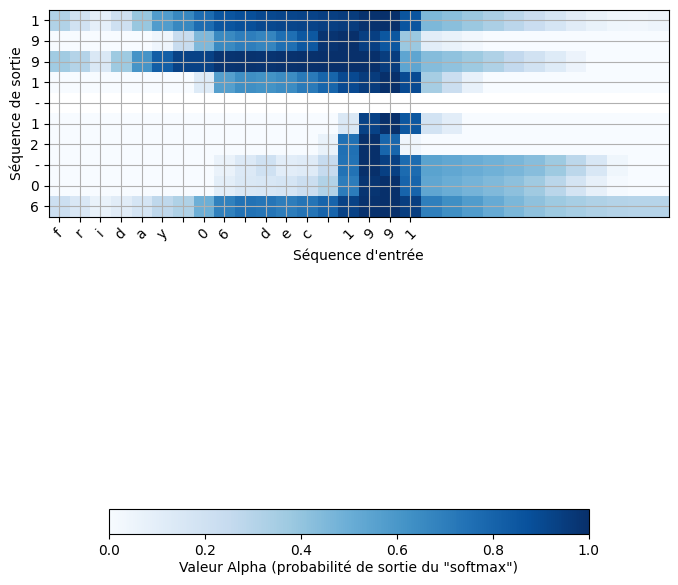

In [ ]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "friday 06 dec 1991", num = 7, n_s = 64);

Sur le graphique généré, vous pouvez observer les valeurs des poids d’attention pour chaque caractère de la sortie prédite. Examinez ce graphique et vérifiez que les endroits où le réseau porte son attention vous semblent cohérents.

Dans l’application de traduction de dates, vous constaterez que la majorité du temps, l’attention aide à prédire l’année, et n’a pas autant d’impact pour prédire le jour ou le mois.


### Félicitations !

Vous êtes arrivé à la fin de ce devoir.

#### Voici ce que vous devez retenir

- Les modèles de traduction automatique peuvent être utilisés pour transformer une séquence en une autre. Ils sont utiles non seulement pour traduire des langues humaines (comme du français vers l’anglais) mais aussi pour des tâches comme la traduction de formats de dates.
- Un mécanisme d’attention permet à un réseau de se concentrer sur les parties les plus pertinentes de l’entrée lors de la production d’une partie spécifique de la sortie.
- Un réseau utilisant un mécanisme d’attention peut traduire des entrées de longueur $T_x$ en sorties de longueur $T_y$, où $T_x$ et $T_y$ peuvent être différents.
- Vous pouvez visualiser les poids d’attention $\alpha^{\langle t,t' \rangle}$ pour voir où le réseau porte son attention lors de la génération de chaque sortie.


Félicitations pour avoir terminé ce devoir ! Vous êtes désormais capable d’implémenter un modèle d’attention et de l’utiliser pour apprendre des correspondances complexes d’une séquence à une autre.